In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path if dataset is in /kaggle/input/)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # <-- update to your actual dataset path
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Check if 'Humanitarian_Class' exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Perform stratified splitting based on 'Humanitarian_Class'
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Save the split datasets to /kaggle/working/
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
val_df.to_csv("/kaggle/working/val_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Display confirmation
print("✅ Data split completed and saved to /kaggle/working/")


✅ Data split completed and saved to /kaggle/working/


Loading FastText model...
Generating FastText embeddings...


100%|██████████| 2713/2713 [00:00<00:00, 31763.85it/s]


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3998 - loss: 1.4585 - val_accuracy: 0.4163 - val_loss: 1.3510 - learning_rate: 0.0010
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6702 - loss: 0.8742 - val_accuracy: 0.6291 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7132 - loss: 0.7760 - val_accuracy: 0.6442 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7332 - loss: 0.7238 - val_accuracy: 0.6368 - val_loss: 0.9133 - learning_rate: 0.0010
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 0.6745 - val_accuracy: 0.6268 - val_loss: 0.9487 - learning_rate: 0.0010
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.6380 - val_accuracy: 0.6574 - val_loss: 0.8839 - learning_rate: 0.0010
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7621 - loss: 0.6273 - val_accura

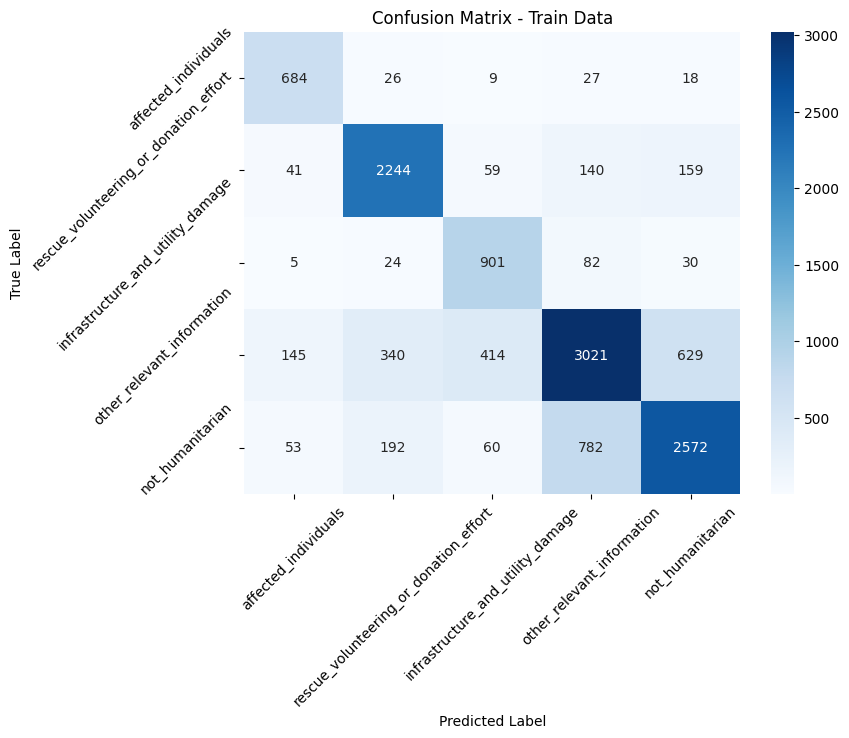

Model saved as 'humanitarian_cnn_model.h5'


In [8]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gensim.downloader as api
from tqdm import tqdm
from collections import Counter

# ========== Load FastText ========== 
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Data ========== 
train_path = "/kaggle/working/train_data.csv"
val_path = "/kaggle/working/val_data.csv"
test_path = "/kaggle/working/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ========== Normalize column names ========== 
for df in [train_df, val_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# ========== Define label mapping ========== 
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# ========== Preprocess Labels ========== 
for df in [train_df, val_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_val = val_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# ========== Fill missing Processed Data ========== 
for df in [train_df, val_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# ========== FastText Embedding Function ========== 
def get_avg_embedding(text, model, dim=300):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

# ========== Generate FastText Vectors ========== 
print("Generating FastText embeddings...") 
X_train_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['processed_data'])]) 
X_val_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(val_df['processed_data'])])
X_test_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['processed_data'])])

# ========== Feature Engineering ========== 
for df in [train_df, val_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_val_features = scaler.transform(val_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_features = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# ========== Combine FastText + Numerical Features ========== 
X_train_combined = np.hstack((X_train_embed, X_train_features))
X_val_combined = np.hstack((X_val_embed, X_val_features))
X_test_combined = np.hstack((X_test_embed, X_test_features))

# ========== Apply SMOTE ========== 
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# ========== CNN Model Definition ========== 
def create_cnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Batch Normalization for stable training
    model.add(Dense(num_classes, activation='softmax'))  # Final layer with softmax

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ========== Train CNN Model ========== 
model = create_cnn_model(X_train_resampled.shape[1], len(label_map))

# Early stopping and learning rate reduction to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=128, validation_data=(X_val_combined, y_val),
                    callbacks=[early_stopping, reduce_lr])

# ========== Evaluate Model ========== 
train_loss, train_acc = model.evaluate(X_train_resampled, y_train_resampled)
val_loss, val_acc = model.evaluate(X_val_combined, y_val)

print(f"Train Accuracy: {train_acc:.4f}")

# ========== Predictions & Evaluation ========== 
y_pred_train = model.predict(X_train_combined)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert probabilities to class labels

# ========== Classification Report ========== 
classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_map.keys())
print(f'Classification Report (Train):\n{classification_rep_train}')

# ========== Confusion Matrix (Train) ========== 
cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Data")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# ========== Save the Model ========== 
model.save("humanitarian_cnn_model.h5")
print("Model saved as 'humanitarian_cnn_model.h5'")
